In [2]:
import nibabel as nib
import numpy as np
import matplotlib.pyplot as plt


In [3]:
def load_nifti(path):
    """Load a NIfTI file and return data array and affine."""
    img = nib.load(path)
    data = img.get_fdata()
    return data, img.affine


def plot_segmentation_overlay(image_path, seg_path, slice_idx=0, alpha=0.4, figsize=(7,7), title="MRI Slice with Tumor Segmentation Overlay"): 
    """ Plot a single slice from a 3D MRI volume with a segmentation overlay. 
    image_path: path to original image slice (can be 2D or 3D) 
    seg_path: path to segmentation mask slice_idx: which slice to display (if more than one) alpha: transparency of segmentation overlay """ 
    
    # Load image + mask 
    img_data, _ = load_nifti(image_path) 
    seg_data, _ = load_nifti(seg_path) 
    
    img_data = np.abs(img_data[0] + 1j * img_data[1]) 


    # Handle both 2D and 3D .nii files 
    if img_data.ndim == 2: 
        img_slice = img_data 
    elif img_data.ndim == 3: 
        img_slice = img_data[:, :, slice_idx] 
    else: 
        raise ValueError(f"Unexpected image shape: {img_data.shape}") 
        
    if seg_data.ndim == 2: 
        seg_slice = seg_data 
    elif seg_data.ndim == 3: 
        seg_slice = seg_data[:, :, slice_idx] 
    else: 
        raise ValueError(f"Unexpected segmentation shape: {seg_data.shape}") 
        
    # Normalize image for visualization 
    img_norm = (img_slice - np.min(img_slice)) / (np.max(img_slice) - np.min(img_slice)) 
    
    plt.figure(figsize=figsize) 
    plt.imshow(img_norm, cmap="gray") 
    
    # Show segmentation overlay (red where seg == 1)

    seg_mask = seg_slice > 0 
    
    plt.imshow(np.ma.masked_where(~seg_mask, seg_mask), cmap="autumn", alpha=alpha) 
    plt.title(title) 
    plt.axis("off") 
    plt.show()

In [4]:
def get_slices_with_tumor(seg_path, label_threshold=0):
    """
    Returns a list of slice indices (along the last axis) that contain tumor.
    
    seg_path: path to 3D segmentation NIfTI
    label_threshold: value above which voxels are considered 'tumor'
                     (use 0 if tumor labels are 1,2,...; use 1 if you only want label>=1, etc.)
    """
    seg_data, _ = load_nifti(seg_path)

    if seg_data.ndim != 3:
        raise ValueError(f"Expected 3D seg, got {seg_data.shape}")

    # Boolean mask of tumor voxels
    tumor_mask = seg_data > label_threshold   # or seg_data == 1 if only class 1

    # For each slice along z, check if any voxel is tumor
    # tumor_mask.any(axis=(0,1)) -> shape (Z,) boolean
    has_tumor_per_slice = tumor_mask.any(axis=(0, 1))
    slice_indices = np.where(has_tumor_per_slice)[0]

    return slice_indices

In [9]:
patient_id = 10

seg_path = f"/ess/scratch/scratch1/rachelgordon/zf_data_192_slices/tumor_segmentations/fastMRI_breast_{patient_id:03d}_2.nii.gz"
slice_idxs = get_slices_with_tumor(seg_path)
print("Slices with tumor:", slice_idxs)
print("Number of slices with tumor:", len(slice_idxs))

Slices with tumor: [56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77]
Number of slices with tumor: 22


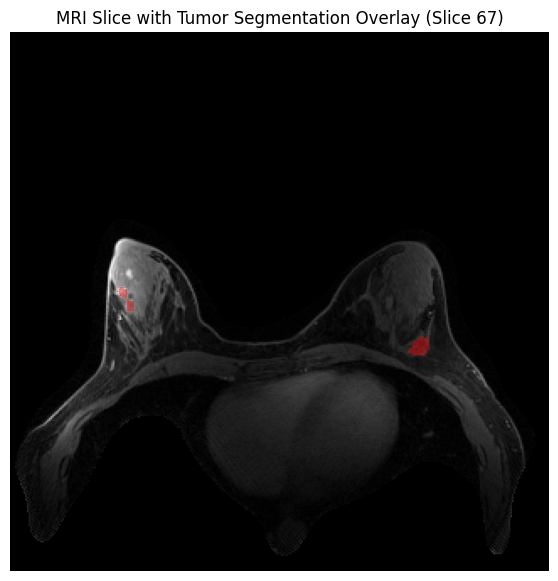

In [12]:
slice_idx = 67
plot_segmentation_overlay(
    image_path=f'/ess/scratch/scratch1/rachelgordon/zf_data_192_slices/fastMRI_breast_{patient_id:03d}_2/slice_{slice_idx:03d}_frame_000.nii',
    seg_path=seg_path,
    slice_idx=slice_idx,
    alpha=0.4,
    figsize=(7,7),
    title=f"MRI Slice with Tumor Segmentation Overlay (Slice {slice_idx})"
)